In [2]:
import pandas as pd
import tbitk.data_manager as dm


def get_meta(p):
    d = None
    if p.find('clarius-l7hd'):
        d = 'clarius-l7hd'
    if p.find('butterfly-iq'):
        d = 'butterfly-iq'

# r = r'ONUS-[\d]+HV'

def find_only(p, txt):
    m = re.search(p, txt)
    if m is not None:
        return m[0]
    else:
        return None

def rulers_to_list(j):
    if j: # j isn't an empty dict
        return [ (x['slice'], y['name'], y['points'], y['distance']) for x in j['rulers'] for y in x['rulers'] ]
    else:
        return []

def texts_to_list(j):
    if j:
        return [ (x['slice'], x['text']) for x in j['cornerTexts'] ]
    else:
        return []
    
def load_onsd(data_dir, manual_onsd_dir):
    ds = dm.posix_glob(f'{data_dir}/manual_onsd*')
    ans_r = []
    ans_txt = []
    for d in ds:
        r = r'manual_onsd-(?P<user>[^-]+)-(?P<replicate>[\d]+)'
        m = re.search(r, d)
        user = m.groupdict()['user']
        replicate = m.groupdict()['replicate']
        rulers = dm.posix_glob(f'{d}/**/*rulers.json', recursive=True)
        texts = dm.posix_glob(f'{d}/**/*cornerText.json', recursive=True)
        uns = [ r.replace('rulers', 'BASE') for r in rulers ] + [ t.replace('cornerText', 'BASE') for t in texts ]
        uns = set(uns)
        for u in uns:
            subject_id = find_only(r'ONUS-[\d]+HV', u)
            device = find_only(r'(clarius-l7hd)|(butterfly-iq)', u)
            # print('HERE', subject_id, device)
            r = u.replace('BASE', 'rulers')
            t = u.replace('BASE', 'cornerText')
            f = Path(u.replace('BASE.json', 'mha')).name
            if Path(r).exists():
                with open(r, 'rb') as fp1:
                    j = json.load(fp1)
                    tmp = rulers_to_list(j)
                    for x in range(len(tmp)):
                        ans_r.append((f, x, user, replicate, subject_id, device) + tmp[x])
            if Path(t).exists():
                with open(t, 'rb') as fp2:
                    j = json.load(fp2)
                    tmp = texts_to_list(j)
                    for x in range(len(tmp)):
                        ans_txt.append((f, x, user, replicate, subject_id, device) + tmp[x])
                
    df_rulers = pd.DataFrame(ans_r, columns=['filename', 'ruler_id', 'user', 'replicate', 'subject_id', 'device', 'frame', 'ruler_name', 'ruler_points', 'distance'])
    df_texts = pd.DataFrame(ans_txt, columns=['filename', 'text_id', 'user', 'replicate', 'subject_id', 'device', 'frame', 'text'])
    return df_rulers, df_texts



In [15]:
from pathlib import Path
import re
import json

ruler_files = dm.posix_glob('../../data/HRPO-E01240.1a/manual_onsd-Brad Moore-3/**/*rulers.json', recursive=True)
ruler_files

def load_json(f):
    with open(f, 'rb') as fp:
        j = json.load(fp)
        eye_width = None
        onsd = None
        x = rulers_to_list(j)
        for y in x:
            # print(f'y: {y}')
            try:
                if y[1] == 'ONSD':
                    onsd = y[3]
                elif y[1] == '0':
                    eye_width = y[3]
            except:
                pass            
        return eye_width, onsd
    
ans = { 'ruler_file' : [], 'group' : [], 'subject_id' : [], 'device' : [], 'eye_width' : [], 'onsd' : [] }
for f in ruler_files:
    r = '.*HRPO-E01240.1a/manual_onsd-Brad Moore-3/(?P<subject_id>ONUS-[0-9]+((TBI)|(HV)))/.*'
    m = re.match(r, f)
    subject_id = m.groupdict()['subject_id']
    group = 'TBI' if subject_id.endswith('TBI') else 'HV'
    eye_width, onsd = load_json(f)
    ans['ruler_file'].append(f)
    ans['group'].append(group)
    ans['subject_id'].append(subject_id)
    ans['device'].append('clarius') # is this correct, TBI has different?
    ans['eye_width'].append(eye_width)
    ans['onsd'].append(onsd)

df = pd.DataFrame(ans)
df


,ruler_file,group,subject_id,device,eye_width,onsd
0,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,TBI,ONUS-002TBI,clarius,21.0142,3.3050
1,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,TBI,ONUS-002TBI,clarius,24.5412,3.7383
2,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,TBI,ONUS-002TBI,clarius,22.5400,4.4856
3,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,TBI,ONUS-002TBI,clarius,23.8746,4.3600
4,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,TBI,ONUS-002TBI,clarius,24.1677,3.8678
...,...,...,...,...,...,...
190,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,HV,ONUS-040HV,clarius,25.0417,4.2898
191,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,HV,ONUS-040HV,clarius,NaN,4.6414
192,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,HV,ONUS-040HV,clarius,24.5032,6.0727
193,../data/HRPO-E01240.1a/manual_onsd-Brad Moore-...,HV,ONUS-040HV,clarius,25.7424,3.7732


[Text(0.5, 1.0, 'Scatterplot of ONSD value by group/subject')]

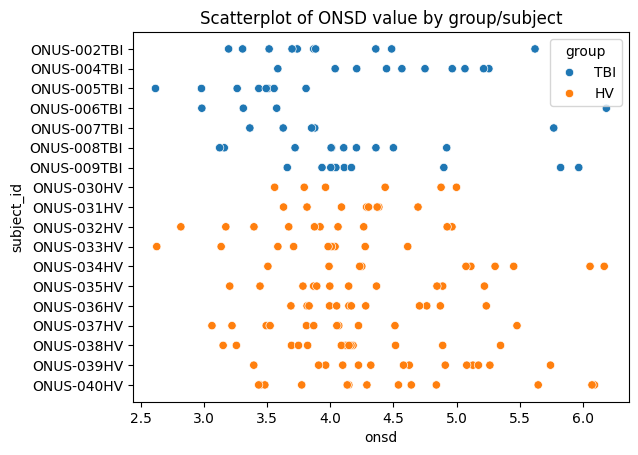

In [26]:
import seaborn as sb

sb.scatterplot(data=df, x='onsd', y='subject_id', hue='group').set(title='Scatterplot of ONSD value by group/subject')

Text(0.5, 1.0, 'Boxplot of ONSD value by group')

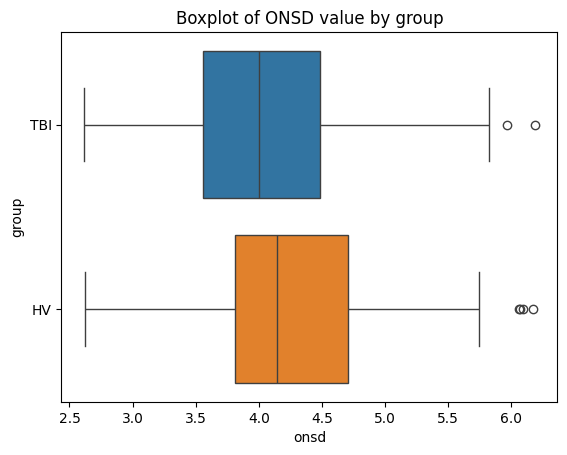

In [28]:
sb.boxplot(data=df, x='onsd', y='group', hue='group').set_title('Boxplot of ONSD value by group')